# Testing and running simulatons

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import random
from collections import Counter, defaultdict
from scipy import integrate
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.cm as cm
import tqdm
import matplotlib.ticker as ticker
from sklearn.metrics import r2_score
import scipy
from sklearn.linear_model import LinearRegression
import time

from simulation.SEIR_model import SEIRModel
from simulation.model_output import SEIRModelOutput
from simulation.error_model import NaiveErrorModel

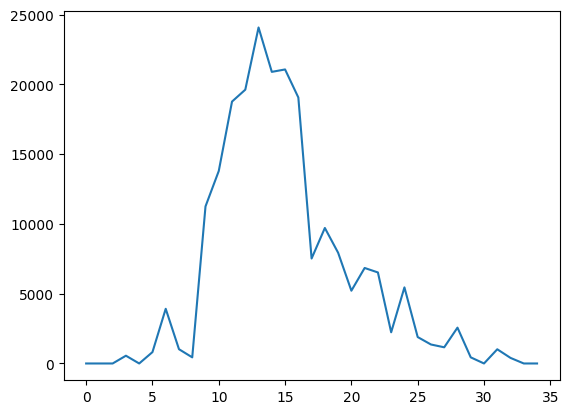

In [2]:
data = pd.read_csv('./data/wave_2014-2015_spb.csv', sep='\t', index_col=0)
weekly_incidence_data = data['total_cases'].to_numpy()[18:-6]
plt.plot(weekly_incidence_data)

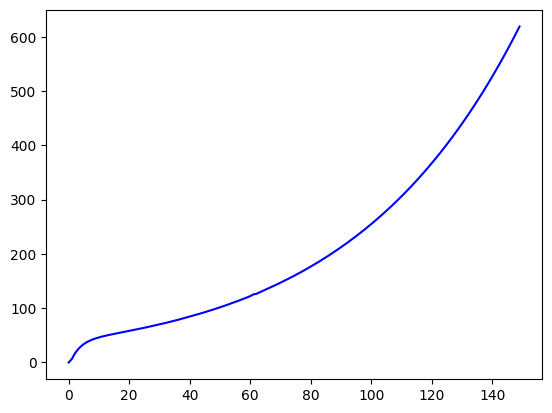

In [13]:
model = SEIRModel(population=5*1e6)
R_0 = 1.5

t_incubation = 2 # in days
t_infective = 7 # in days

alpha = 1/t_incubation
gamma = 1/t_infective
beta = gamma*R_0
init_inf_frac = 0.0001
init_rec_frac = 0.15
tmax = 150 # days

res = model.simulate(alpha=1/7, beta=(1/7)*1.5, gamma=1/7, init_inf_frac=1e-4, init_rec_frac=0.15)

plt.plot(res.daily_incidence, color='blue', alpha=1)

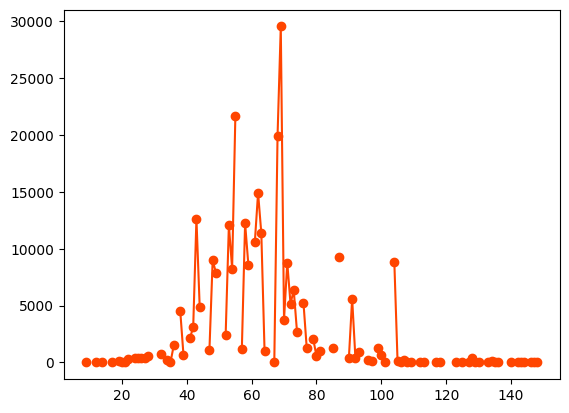

In [12]:
error_model = NaiveErrorModel(res.daily_incidence)
error_model.add_noise()
plt.plot(error_model.incidence_arr, '-o', color='OrangeRed')

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


Text(0.5, 1.0, '$R_0 \\in [$1.0, 1.5$]$, $\\tau (inc.) \\in [$1, 4$]$,$\\tau (inf.) \\in [$4, 8$]$, immune fraction $\\in [$0.01, 0.2$]$')

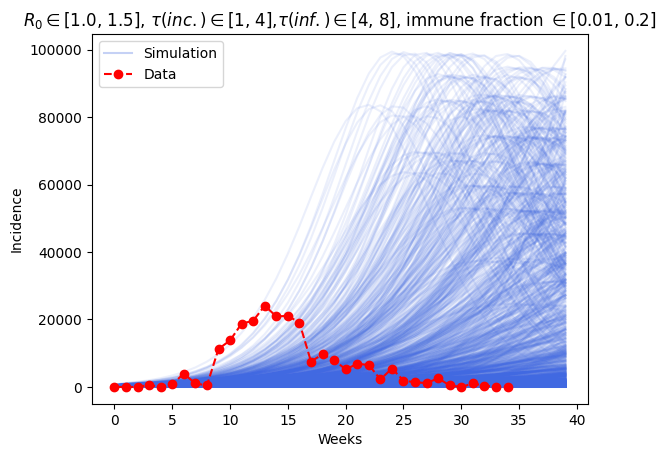

In [24]:
MAX_INCIDENCE_LIMITATION = 1e5

for t_incubation in tqdm.tqdm(t_incubation_arr):
    for t_infective in t_infective_arr:
        for R_0 in R_0_arr:
            for init_rec_frac in init_rec_frac_arr:
                for init_inf_frac in init_inf_frac_arr:
                    alpha = 1/t_incubation
                    gamma = 1/t_infective
                    beta = gamma*R_0
                    res = model.simulate(alpha=alpha, beta=beta, gamma=gamma, 
                                        init_inf_frac=init_inf_frac, 
                                        init_rec_frac=init_rec_frac, tmax=tmax)
                    if (res.weekly_incidence < MAX_INCIDENCE_LIMITATION).all():
                        plt.plot(res.weekly_incidence, color='RoyalBlue', alpha=0.1)
res = model.simulate(alpha=alpha, beta=beta, gamma=gamma, 
                                     init_inf_frac=0, 
                                     init_rec_frac=init_rec_frac, tmax=tmax)
plt.plot(res.weekly_incidence, color='RoyalBlue', alpha=0.3, label='Simulation')
plt.plot(weekly_incidence_data, '--o', color='red', label='Data')    
plt.xlabel('Weeks')
plt.ylabel('Incidence')
plt.legend()
plt.title(r'$R_0 \in [${}, {}$]$, $\tau (inc.) \in [${}, {}$]$,$\tau (inf.) \in [${}, {}$]$, immune fraction $\in [${}, {}$]$'.format(R_0_arr[0], R_0_arr[-1],
                                               t_incubation_arr[0], t_incubation_arr[-1],
                                               t_infective_arr[0], t_infective_arr[-1],
                                               init_rec_frac_arr[0], init_rec_frac_arr[-1]))

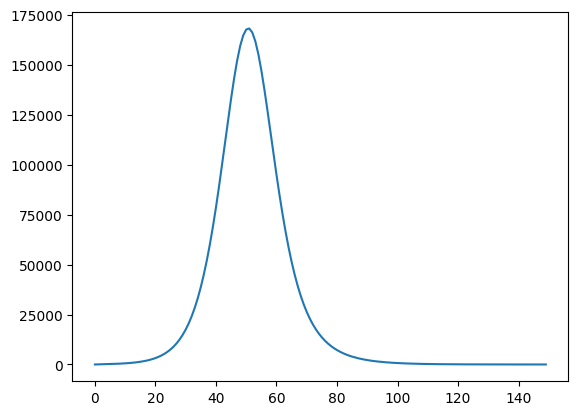

In [14]:
plt.plot(res.daily_incidence)

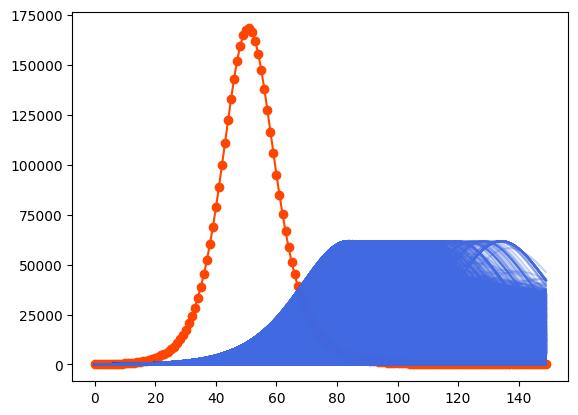

In [28]:
fig, ax = plt.subplots()


t_incubation_arr = np.arange(1, 5)
t_infective_arr = np.arange(4, 9)
R_0_arr = np.linspace(1, 1.5, 5)
init_inf_frac_arr = np.linspace(1e-6, 1e-4, 5)
init_rec_frac_arr = np.linspace(1e-2, 2e-1, 5)

ax.plot(res.daily_incidence, '-o', color='OrangeRed')

def AnnealingModel(x):
    alpha, R_0, gamma, init_inf_frac, init_rec_frac = x
    sim = model.simulate(alpha=alpha, beta=gamma*R_0, gamma=gamma, 
                         init_inf_frac=init_inf_frac, init_rec_frac=init_rec_frac, 
                         tmax=tmax)
    daily_incidence_sim = sim.daily_incidence
    ax.plot(daily_incidence_sim, color='RoyalBlue', alpha=0.3)
    return -r2_score(daily_incidence_sim, res.daily_incidence)


lw = [1/t_incubation_arr[-1], R_0_arr[0], 1/t_infective_arr[-1],  init_inf_frac_arr[0], init_rec_frac_arr[0]]
up = [1/t_incubation_arr[0], R_0_arr[-1], 1/t_infective_arr[0], init_inf_frac_arr[-1], init_rec_frac_arr[-1]]

ret = scipy.optimize.dual_annealing(AnnealingModel, bounds=list(zip(lw, up)))

In [27]:
lw

[np.float64(0.25),
 np.float64(1.0),
 np.float64(0.125),
 np.float64(1e-06),
 np.float64(0.01)]

In [25]:
up

[np.float64(1.0),
 np.float64(1.5),
 np.float64(0.25),
 np.float64(0.0001),
 np.float64(0.2)]

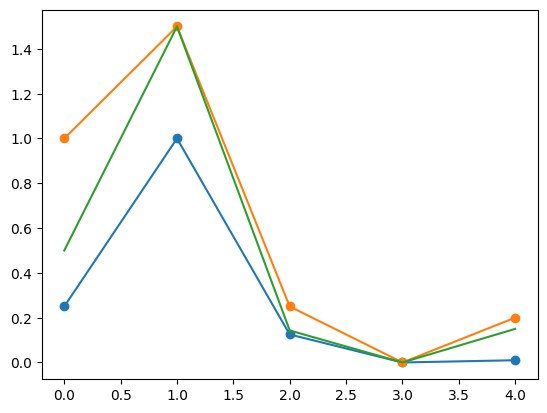

In [32]:
plt.plot(lw, '-o')
plt.plot(up, '-o')
plt.plot([1/2, 1.5, 1/7, 1e-4, 0.15])

In [ ]:

alpha=1/2, beta=1/3*1.5, gamma=1/7, init_inf_frac=1e-4, init_rec_frac=0.15

In [20]:
ret.fun

5.860529071264124

In [164]:
beta_best, init_rec_frac_best = ret.x[0], ret.x[1]
print(beta_best, init_inf_frac)
print('R^2 score:', ret.fun)

6.352802096407088e-09 1e-05
R^2 score: 0.3250629360675539


In [183]:
model = SEIRModel(population=5*10e6)
alpha = 0.05
beta = 4.5e-9
gamma = 1/7
init_inf_frac = 1e-5
init_rec_frac = 1e-5
tmax = 245 # days
res = model.simulate(alpha=alpha, beta=beta, gamma=gamma, 
                     init_inf_frac=init_inf_frac, 
                     init_rec_frac=init_rec_frac, tmax=tmax)